In [31]:
import pandas as pd
import numpy as np
import intake

In [32]:
cat = intake.open_catalog('../catalogs/catalog.yml')
measures = cat.measures.read().set_index('cdtfa_id')

In [33]:
# if this file can't be found, run notebook 1 to generate
measures_joined = pd.read_parquet('../data/interim/measures_cdtfa_joined.parquet')

In [34]:
sco_url = 'https://bythenumbers.sco.ca.gov/download/6dj3-r4jw/application%2Fvnd.openxmlformats-officedocument.spreadsheetml.sheet'

In [35]:
sco_entities = pd.read_excel(sco_url, sheet_name='ENTITIES')

In [36]:
sco_rev_exp = pd.read_excel(sco_url, sheet_name='TO_REV_EXP')
sco_rev_exp = sco_rev_exp[sco_rev_exp['Fiscal Year'] == 2019]

In [37]:
lost_transit_funding_2019 = measures_joined[['Calendar Year', 'Quarter', 'Net Amount','county_name', 'county_fips', 'total_pct_transit', 'pct_transit_ops']]

In [38]:
lost_transit_funding_2019['county_name'] = lost_transit_funding_2019['county_name'].replace('Monterey-Salinas Transit District', 'Monterey')

<ipython-input-38-8c5d669f1ea1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_transit_funding_2019['county_name'] = lost_transit_funding_2019['county_name'].replace('Monterey-Salinas Transit District', 'Monterey')


In [39]:
lost_transit_funding_2019['Net Transit Ops'] = lost_transit_funding_2019['Net Amount'] * lost_transit_funding_2019['pct_transit_ops']
lost_transit_funding_2019['Net Transit All'] = lost_transit_funding_2019['Net Amount'] * lost_transit_funding_2019['total_pct_transit']

<ipython-input-39-6806448d0ebc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_transit_funding_2019['Net Transit Ops'] = lost_transit_funding_2019['Net Amount'] * lost_transit_funding_2019['pct_transit_ops']
<ipython-input-39-6806448d0ebc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_transit_funding_2019['Net Transit All'] = lost_transit_funding_2019['Net Amount'] * lost_transit_funding_2019['total_pct_transit']


In [40]:
sco_rev_exp.columns[sco_rev_exp.columns.str.contains('Fares')]

Index(['Passenger Fares_ Actual_Operating Revenues', 'Passenger Fares_ Budget_Operating Revenues'], dtype='object')

In [41]:
county_lost_funding_19 = lost_transit_funding_2019.groupby('county_name').sum()[['Net Transit Ops', 'Net Transit All']]

In [42]:
agency_sco_total_19 = sco_rev_exp[['Entity ID', 'Entity Name', 'Total Operating Revenues_ Actual_Operating Revenues',
           'Total Operating Expenses_ Actual_Operating Expenses',
            'Total Nonoperating Revenues_ Actual_Nonoperating Revenues',
            'Total Nonoperating Expenses_ Actual_Nonoperating Expenses',
            'Passenger Fares_ Actual_Operating Revenues',
            'Local Funds Dedicated to Transit at Their Source_Local Government Funds_ Actual_Nonoperating Revenues']]

In [43]:
county_sco_total_19 = (agency_sco_total_19.set_index('Entity ID')
                       .join(sco_entities[['Entity ID', 'County Name']].set_index('Entity ID'))
                      .groupby('County Name').sum())
county_sco_total_19['Total Revenues_Actual'] = (county_sco_total_19['Total Nonoperating Revenues_ Actual_Nonoperating Revenues'] 
                                                + county_sco_total_19['Total Operating Revenues_ Actual_Operating Revenues'])

In [44]:
all_funding_19 = county_lost_funding_19.join(county_sco_total_19)

all_funding_19['Fares ratio of total'] = (
    all_funding_19['Passenger Fares_ Actual_Operating Revenues']
    / all_funding_19['Total Revenues_Actual'])

all_funding_19['LOST ratio of total'] = all_funding_19['Net Transit All'] / all_funding_19['Total Revenues_Actual']
all_funding_19['LOST operations ratio of total'] = all_funding_19['Net Transit Ops'] / all_funding_19['Total Revenues_Actual']

all_funding_19['LOST operations funding ratio of operating expenses'] = (
    all_funding_19['Net Transit Ops'] 
    / all_funding_19['Total Operating Expenses_ Actual_Operating Expenses'] )

all_funding_19 = all_funding_19.rename(columns={'Net Transit Ops': 'LOST Transit Ops', 'Net Transit All': 'LOST Transit All'})

In [45]:
all_funding_19

,LOST Transit Ops,LOST Transit All,Total Operating Revenues_ Actual_Operating Revenues,Total Operating Expenses_ Actual_Operating Expenses,Total Nonoperating Revenues_ Actual_Nonoperating Revenues,Total Nonoperating Expenses_ Actual_Nonoperating Expenses,Passenger Fares_ Actual_Operating Revenues,Local Funds Dedicated to Transit at Their Source_Local Government Funds_ Actual_Nonoperating Revenues,Total Revenues_Actual,Fares ratio of total,LOST ratio of total,LOST operations ratio of total,LOST operations funding ratio of operating expenses
county_name,,,,,,,,,,,,,
Alameda,1.360473e+07,2.742659e+07,666426629.0,1.551864e+09,9.235469e+08,55038921.0,557671334.0,131037991.0,1.589974e+09,0.350743,0.017250,0.008557,0.008767
Contra Costa,5.947064e+06,1.034409e+07,10643535.0,8.655780e+07,6.186824e+07,78037.0,7733673.0,10781110.0,7.251178e+07,0.106654,0.142654,0.082015,0.068706
Fresno,0.000000e+00,8.778743e+06,14228380.0,8.060579e+07,5.271284e+07,72504.0,10483906.0,16060079.0,6.694122e+07,0.156614,0.131141,0.000000,0.000000
Imperial,0.000000e+00,1.044651e+05,2483135.0,9.737597e+06,7.216353e+06,1424572.0,837757.0,0.0,9.699488e+06,0.086371,0.010770,0.000000,0.000000
Los Angeles,1.576454e+08,8.672525e+08,686819424.0,3.767198e+09,1.589747e+09,283577741.0,455341357.0,443659070.0,2.276566e+09,0.200012,0.380948,0.069247,0.041847
Madera,0.000000e+00,7.620175e+04,694261.0,2.864945e+06,4.438425e+06,45579.0,162886.0,0.0,5.132686e+06,0.031735,0.014846,0.000000,0.000000
Marin,5.003512e+06,5.395944e+06,9137800.0,8.141770e+07,8.122895e+07,6361764.0,7660372.0,55973436.0,9.036675e+07,0.084770,0.059712,0.055369,0.061455
Merced,3.559832e+05,3.559832e+05,1625544.0,1.684783e+07,1.762549e+07,130510.0,1350591.0,358494.0,1.925103e+07,0.070157,0.018492,0.018492,0.021129
Monterey,3.567664e+06,3.567664e+06,9146630.0,5.622159e+07,4.384214e+07,985757.0,8715328.0,10365729.0,5.298877e+07,0.164475,0.067329,0.067329,0.063457


In [46]:
all_funding_19['Local Funds Dedicated to Transit at Their Source_Local Government Funds_ Actual_Nonoperating Revenues'] - all_funding_19['LOST Transit All']

county_name
Alameda           1.036114e+08
Contra Costa      4.370150e+05
Fresno            7.281336e+06
Imperial         -1.044651e+05
Los Angeles      -4.235934e+08
Madera           -7.620175e+04
Marin             5.057749e+07
Merced            2.510790e+03
Monterey          6.798065e+06
Napa              0.000000e+00
Orange           -1.400052e+07
Riverside        -5.765372e+06
Sacramento        3.289011e+07
San Benito       -2.045626e+05
San Bernardino   -2.792685e+06
San Diego         1.979493e+07
San Francisco     5.505661e+07
San Joaquin       1.154652e+07
San Mateo        -1.879565e+07
Santa Barbara     3.783388e+06
Santa Clara       2.876660e+08
Santa Cruz        2.203616e+07
Sonoma           -4.876410e+05
Sonoma/Marin               NaN
Stanislaus       -8.201339e+05
Tulare            1.050912e+06
dtype: float64

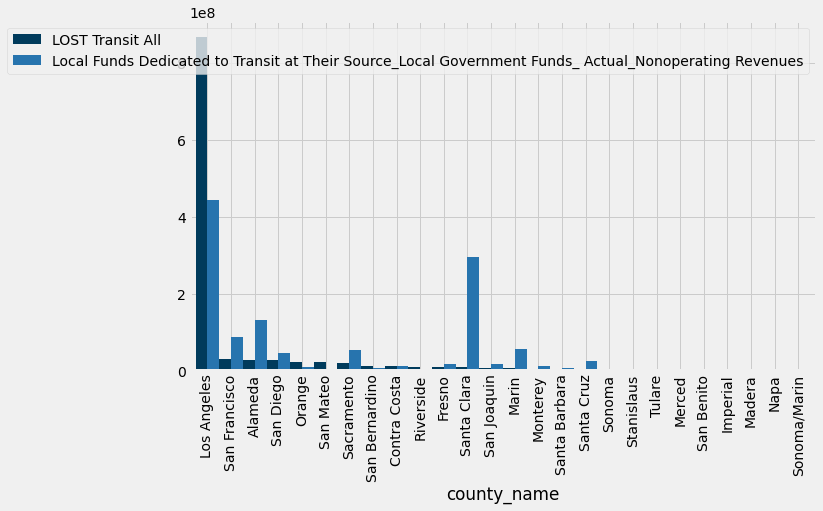

In [47]:
(all_funding_19.sort_values('LOST Transit All', ascending=False)
 [['LOST Transit All', 'Local Funds Dedicated to Transit at Their Source_Local Government Funds_ Actual_Nonoperating Revenues']]
 .plot(kind='bar', width=1, figsize=(10,6)) );

In [48]:
import plotly.express as px

In [49]:
all_funding_19['LOST percentage of total'] = all_funding_19['LOST ratio of total']*100
all_funding_19['Fares percentage of total'] = all_funding_19['Fares ratio of total']*100
# all_funding_19 = all_funding_19.rename(columns={'Fares ratio of total': 'Fares percentage of total',
#                                                'LOST ratio of total': 'LOST percentage of total'})

In [50]:
# fig = px.bar(all_funding_19.sort_values('LOST percentage of total', ascending=False),
#              x='County', y=['LOST percentage of total', 'Fares percentage of total'],
#             labels={'value':'Percentage of Total Transit Funding',
#                    'variable':''},
#             title='Comparing LOST Funding to Passenger Fares in each County')

In [51]:
all_funding_19['County'] = all_funding_19.index

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ucla')

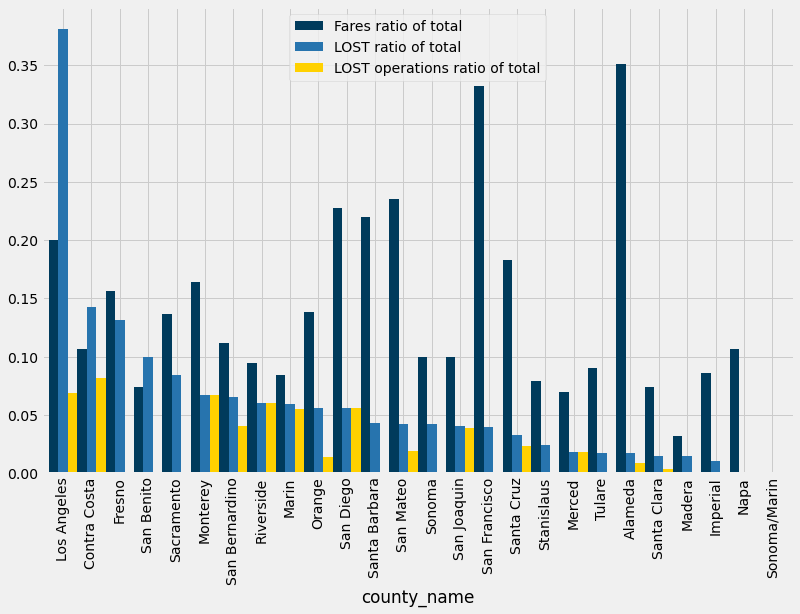

In [54]:
#this info might be better presented as a stacked bar with all funding sources?

(all_funding_19.sort_values('LOST ratio of total', ascending=False)
 [['Fares ratio of total', 'LOST ratio of total', 'LOST operations ratio of total']]
 .plot(kind='bar', width=1, figsize=(12,8)) );

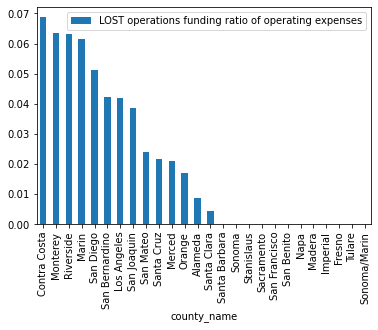

In [19]:
all_funding_19.sort_values('LOST operations funding ratio of operating expenses', ascending=False)[['LOST operations funding ratio of operating expenses']].plot(kind='bar');

In [20]:
measures

,ballot_designation,county_fips,county_name,lost_rate,total_pct_transit,pct_transit_ops,pct_transit_capital,pct_local_return,pct_hwy,pct_streets,pct_discretionary,year,amendable,change_feq,two_thirds_req
cdtfa_id,,,,,,,,,,,,,,,
79,Measure B,6001,Alameda,0.00500,0.5900,NaN,NaN,0.2400,0.1700,NaN,NaN,2000.0,True,NaN,True
377,Measure BB,6001,Alameda,0.01000,0.4800,0.2381,0.1400,NaN,0.3000,0.0900,NaN,2014.0,True,NaN,True
24,Measure J,6013,Contra Costa,0.00500,0.3270,0.1880,0.1390,NaN,0.2550,26.4000,0.600,2004.0,True,NaN,True
12,Measure C Extension,6019,Fresno,0.00500,0.3200,NaN,0.0600,0.3460,0.2940,NaN,NaN,2007.0,True,NaN,NaN
29,Measure D,6025,Imperial,0.00500,0.0200,NaN,NaN,NaN,0.0500,0.9300,NaN,2008.0,True,NaN,True
5,Proposition A,6037,Los Angeles,0.00500,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,1980.0,NaN,NaN,NaN
35,Proposition C,6037,Los Angeles,0.00500,0.5500,NaN,NaN,0.2000,0.2500,NaN,NaN,1990.0,NaN,NaN,NaN
217,Measure R,6037,Los Angeles,0.00500,0.6500,0.2500,0.4000,0.1500,0.2000,NaN,NaN,2008.0,True,10.0,NaN
576,Measure M,6037,Los Angeles,0.00500,0.6500,0.2700,0.3800,0.1600,0.1700,0.0200,NaN,2016.0,True,NaN,NaN


In [21]:
all_funding_19['Farebox Recovery'] = all_funding_19['Total Operating Expenses_ Actual_Operating Expenses'] / all_funding_19['Passenger Fares_ Actual_Operating Revenues']

In [22]:
all_funding_19['LOST Percentage'] = all_funding_19['Total Operating Expenses_ Actual_Operating Expenses'] / all_funding_19['LOST Transit All']

<AxesSubplot:xlabel='county_name'>

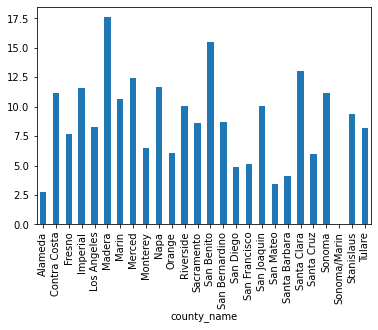

In [23]:
all_funding_19['Farebox Recovery'].plot(kind='bar')

<AxesSubplot:xlabel='county_name'>

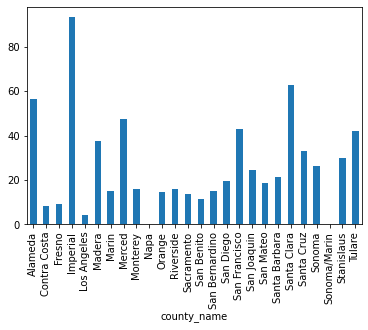

In [24]:
all_funding_19['LOST Percentage'].plot(kind='bar')